## Titanic Dataset Report 


The titanic dataset contains important passenger information. The is classed by metrics such as sex, survival status (result of the disaster), age, voyage class, and name. 

This report will explore the statictics difference of these factors. 
These will include the following:

Are individuals in higher pclass more likely to survive?
How influential is sex?
Is the sex surivial proportion equal across the classes?
Across children, teens, adult, and eldery, is there a statistic difference in survival?

These questions hope to reveal the  contextual social framework which made survival a more possible likeihood.

In [20]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
sns.set(style="ticks")
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, cross_val_score


In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = pd.concat([train,test],axis = 0)
data['Pclass'] = data['Pclass'].astype(object)

In [22]:
display(data.groupby('Sex').agg(count = ('Sex', 'count'),mean_age = ('Age', 'mean'), survived = ('Survived','count')))
display(data.groupby('Pclass').agg(count = ('Sex','count'), mean_age = ('Age','mean')))
display(pd.crosstab(data['Sex'], data['Pclass'])
)
display(data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

display(data[["Pclass","Sex", "Survived"]].groupby(['Sex','Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=False))


,count,mean_age,survived
Sex,,,
female,466,28.687088,314
male,843,30.585228,577


,count,mean_age
Pclass,,
1,323,39.159930
2,277,29.506705
3,709,24.816367


Pclass,1,2,3
Sex,,,
female,144,106,216
male,179,171,493


,Sex,Survived
0,female,0.742038
1,male,0.188908


,Sex,Pclass,Survived
2,female,3,0.500000
5,male,3,0.135447
1,female,2,0.921053
4,male,2,0.157407
0,female,1,0.968085
3,male,1,0.368852


Overall within the Titanic, and across the classes, males outpopulated females.The overall of mean age across both sexes is about 30. Naturally there are more passengers in lower class seats. The mean age increased as you move up the class. Individuals aged are more likely to be in the upper classes. 

In terms of survival, females vastly outnumber males within each class. First class passengers were more likely to survive than lower classes. Almost all females in class 2 and 3 survived, but in class 1, only half lived. In classes 2 and 3, male survival was low. If you were males on aboard the titantic, you were likely to have passed. In class 3, about 40% of males lived. 

Unfortunaly, the existence of financial biases exists for the wealthy, but with the high percentage of female survival, chilvarly for women is just as important.

One thing that I have excluded is the important of age. That will be explored later.

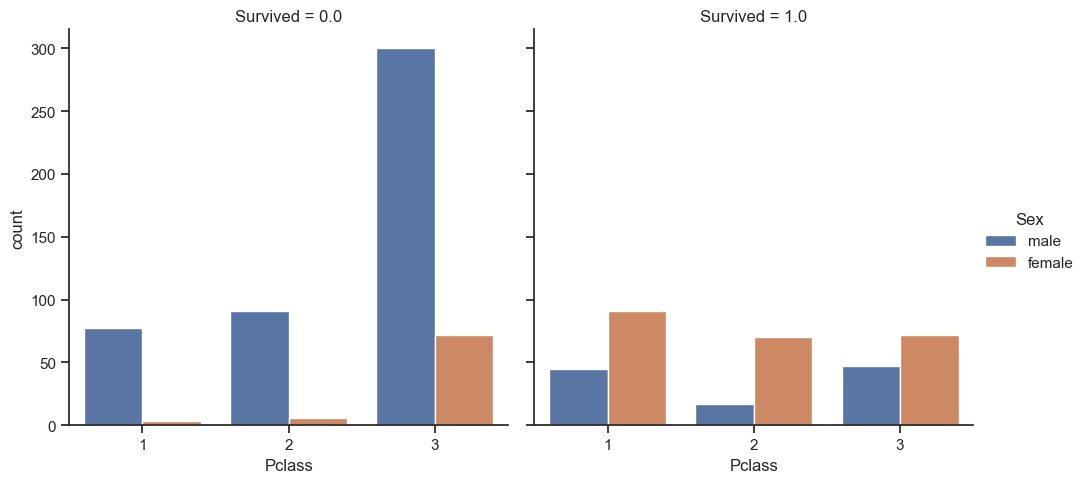

In [23]:
sns.catplot( x = 'Pclass',data=data, hue='Sex',col = 'Survived',kind='count')

c:\Users\Ivan Shamoon\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


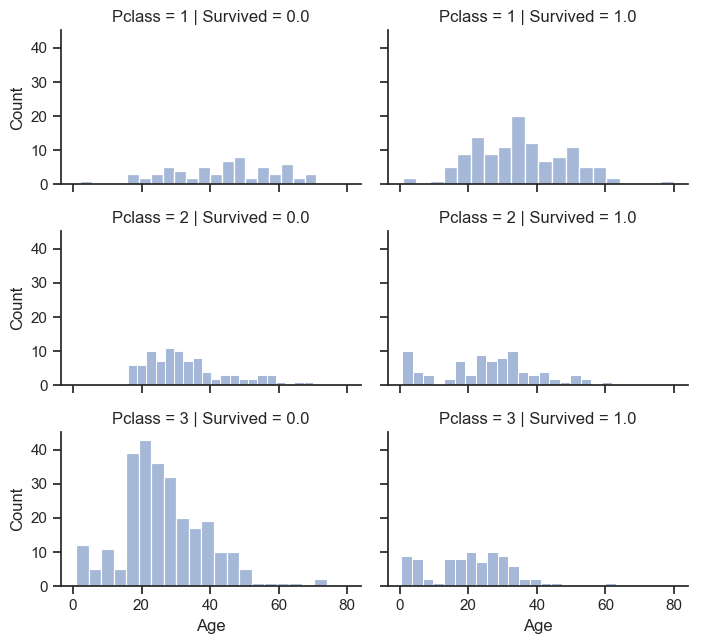

In [24]:
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(sns.histplot, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [25]:
# Remove nas from age columns.
# Replace na rows with the mean from the class and sex.
# Since there is a little of deviation across class this provides a more honest fill.
display(data['Age'].isna().sum())
data['Age'] = data['Age'].fillna(data.groupby(['Pclass','Sex'])['Age'].transform('mean'))

# Create age brackets spread by 10 years
data['Age_band'] = pd.cut(data['Age'], int(round(data.Age.max() - data.Age.min())/10))



263

In [26]:
# Segment age into its designated age brackets
bins =  [0,10,20,30,40,50,60,70]
labels = [0,1,2,3,4,5,6]

data['Age_cat'] = pd.cut(x = data['Age'], bins = bins, labels=labels, include_lowest= True)

In [27]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_band,Age_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,"(20.128, 30.106]",2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,"(30.106, 40.085]",3
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20.128, 30.106]",2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,"(30.106, 40.085]",3
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,"(30.106, 40.085]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,25.962264,0,0,A.5. 3236,8.0500,NaN,S,"(20.128, 30.106]",2
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,"(30.106, 40.085]",3
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,"(30.106, 40.085]",3
416,1308,NaN,3,"Ware, Mr. Frederick",male,25.962264,0,0,359309,8.0500,NaN,S,"(20.128, 30.106]",2


<AxesSubplot:xlabel='Age_cat', ylabel='Count'>

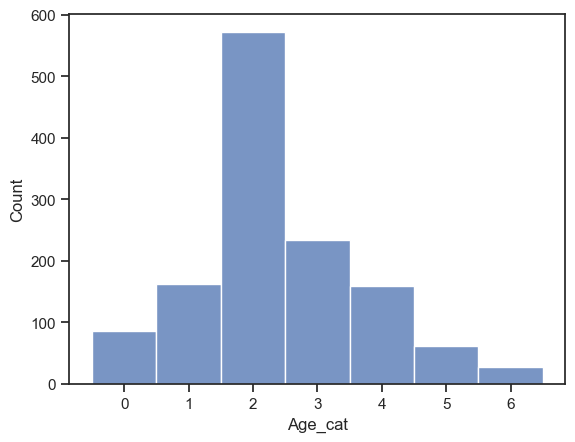

In [28]:
sns.histplot(data['Age_cat'])

This part of the report will deploy machine learning and statiscal test to ascertain the actuaility of assumptions made earlier. 

Including whether individuals in higher class seats have an unequal proportion compared to other seats.
Do certain age brackets have a higher likelihood for survival.


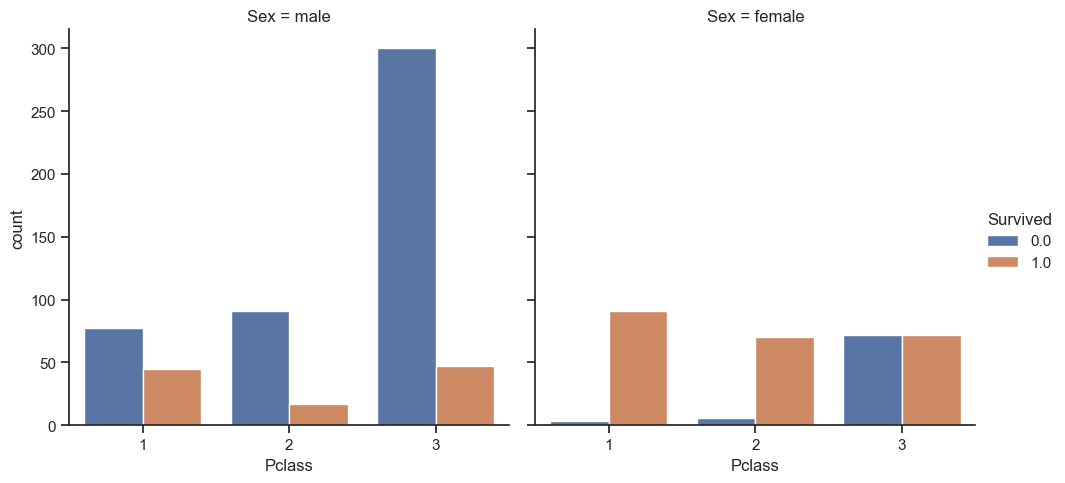

In [13]:
sns.catplot(x = 'Pclass', hue = 'Survived', col = 'Sex',data = data, kind = 'count')



This inequality is quite apparent. Nevertheless, a chi-squared test calculating the test of homogeneity willl be deployed.

In [29]:
combined_tab = pd.crosstab(data['Survived'], [data['Sex'], data['Pclass']])
combined_tab = pd.DataFrame(combined_tab)
combined_tab.columns = ['F1','F2','F3','M1', 'M2', 'M3']
combined_tab.index = ['0','1']
combined_tab 

,F1,F2,F3,M1,M2,M3
0,3,6,72,77,91,300
1,91,70,72,45,17,47


The assumptions for the chi-squared test is mostly statisfied. Only a single cell as a count less than 5, but this is permissible as it is the only execption within the table.

In [30]:
from scipy.stats  import chi2_contingency

stat, p, dof, expected = chi2_contingency(combined_tab)

print('Test statistic: ', str(stat), '\t', 'p-value: ', str(p))


Test statistic:  350.67530839575556 	 p-value:  1.2523073473573166e-73


With an observed p-value less than the 0.05 significance level, there is strong evidence that groups categorised by pclass and sex testing mortality is different. 

However, to observed where the difference(s) lie, a post-hoc test will actualise this.

In [32]:
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

# gathering all combinations for post-hoc chi2
all_combinations = list(combinations(combined_tab.columns, 2))
p_vals = []

for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = pd.concat([combined_tab[comb[0]].reset_index(drop=True), combined_tab[comb[1]].reset_index(drop=True)], axis=1)

    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
    p_vals.append(p)

# Get reject list and corrected p values using Bonferroni correction
reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]

post_hoc = {"name": all_combinations, "pvalue": p_vals, 'adjusted pvalue': corrected_p_vals, 'reject': reject_list}
pd.DataFrame(post_hoc)


,name,pvalue,adjusted pvalue,reject
0,"(F1, F2)",3.090729e-01,3.311495e-01,False
1,"(F1, F3)",8.926032e-14,1.673631e-13,True
2,"(F1, M1)",5.603075e-19,1.680923e-18,True
3,"(F1, M2)",5.230128e-30,2.615064e-29,True
4,"(F1, M3)",5.793893e-53,8.690839e-52,True
5,"(F2, F3)",1.363739e-09,2.272898e-09,True
6,"(F2, M1)",5.906334e-14,1.265643e-13,True
7,"(F2, M2)",7.817975e-24,2.931741e-23,True
8,"(F2, M3)",7.117424e-43,5.338068e-42,True
9,"(F3, M1)",4.304552e-02,4.966791e-02,True


In most instance, with the exception of F1 and F2, and M2 and M3, there is a signifcant difference. It is important to note all combinations of opposite sex is signifcant. 

# Machine learning

Before machine learning deployment, the data must be cleaned.

In [33]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return ms

In [34]:
missingdata(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


With a majority of cabin rows being null, and considering the size of the data, its non-consideration with modelling is a non-issue.

In [35]:
# Get items for X_Train

bins =  [0,10,20,30,40,50,60,70]
labels = [0,1,2,3,4,5,6] 

# Make sex numeric
train['Gender'] = pd.factorize(train['Sex'])[0] 

# Make Embarked Numeric
train['Embarked'] = pd.factorize(train['Embarked'])[0]

#  Impute then Categorise age
train['Age'] = train['Age'].fillna(train.groupby(['Pclass','Sex'])['Age'].transform('mean'))
train['Age_cat'] = pd.cut(x = train['Age'], bins = bins, labels=labels, include_lowest= True)

# Categorise fare 
train['Fare_bracket'] = pd.qcut(train['Fare'], 4)
train['Fare_num'] = pd.factorize(train['Fare_bracket'])[0]

# Drop uneeded columns
train = train.drop('Cabin', axis = 1)
train = train.drop('Name',axis = 1)


In [36]:
# Set variables for test
items = ['Age_cat','Pclass','Gender','Embarked','SibSp','Parch','Fare_num']


In [37]:
# Get x and y list from train
X = train[items]
y = train['Survived']
scaler = StandardScaler()
scale_X = scaler.fit_transform(X)

In [38]:
X = pd.get_dummies(X, columns = ['Age_cat'])
scaler = StandardScaler()
scale_X = scaler.fit_transform(X)

In [39]:
def print_acc(x):
    return print("Cross Validation accuracy: " + str(round(x,5)*100))

### K-Nearest Neighbours

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

# Get train test split 
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=5)
knn_acc = cross_val_score(knn, scale_X, y, cv = 10).mean()
print_acc(knn_acc)

Cross Validation accuracy: 78.915


### Logistic Regression

In [41]:

logreg = LogisticRegression()
logreg_acc = cross_val_score(logreg, scale_X, y, cv = 10).mean()
print_acc(logreg_acc)

Cross Validation accuracy: 81.26


### Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 100, bootstrap= True )
rf_acc = cross_val_score(rf, X, y, cv = 10).mean()
print_acc(rf_acc)

Cross Validation accuracy: 81.6


### Support Vector machine

In [ ]:
from sklearn.svm import SVC, LinearSVC
svm = SVC()
svm_acc = cross_val_score(svm, scale_X, y, cv =10).mean()
print_acc(svm_acc)

Cross Validation accuracy: 82.042


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_acc = cross_val_score(dt, scale_X, y, cv = 10).mean()
print_acc(dt_acc)

Cross Validation accuracy: 80.146


### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_acc = cross_val_score(ada_clf, X, y, cv = 10).mean()
print_acc(ada_acc)

Cross Validation accuracy: 79.801


### Results: 

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machine', 'KNN', 'Logistic Regression', 
              'Random Forest', 'AdaBoostClassifier', 
              'Decision Tree'],
    'Score': [svm_acc, knn_acc, 
              logreg_acc, rf_acc, ada_acc, dt_acc]})
models.sort_values(by='Score',ascending=False)

,Model,Score
0,Support Vector Machine,0.820424
3,Random Forest,0.816005
2,Logistic Regression,0.812597
5,Decision Tree,0.801461
4,AdaBoostClassifier,0.798015
1,KNN,0.789151


Support Vector Machine, Random Forest, and Logistic Regression produce the best accuracies. To better fine-tune these classifiers, parameters for these models will be optimised.

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear','sigmoid']}

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

svm = SVC()
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001,],
              'kernel': ['rbf','linear']}

svm_params = GridSearchCV(svm, param_grid = param_grid, scoring = 'accuracy' , cv = 5, verbose = 1)

svm_params.fit(scale_X, y)
print("Best Prams and accuracy")
print(svm_params.best_params_)
print(svm_params.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=1)

In [47]:
print(svm_params.best_params_)
print(svm_params.best_score_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [60]:
from sklearn.ensemble import RandomForestClassifier
 
rf_model = RandomForestClassifier()

n_estim=range(100,1000,100)

param_grid = {'n_estimators' : n_estim,
              'criterion': ['gini','log_loss'],
              'bootstrap': [False, True]}


rf_params = GridSearchCV(rf_model, param_grid = param_grid, scoring = 'accuracy' , cv = 5, verbose = 1)

rf_params.fit(scale_X, y)
print("Best Prams and accuracy")
print(rf_params.best_params_)
print(rf_params.best_params_)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Prams and accuracy
{'bootstrap': True, 'criterion': 'log_loss', 'n_estimators': 800}
{'bootstrap': True, 'criterion': 'log_loss', 'n_estimators': 800}


In [61]:
print(rf_params.best_score_)

0.8193459293201932


# Conclusion

The titanic dataset is an interesting data set to analysed. The survirors of the tradegy was depended on a variety of factors. In terms of machine learning, the random forest classifer was the best managing to yield an accuracy of 82%. This indicates the data has distinctive features which hint towards a result. Reguardless it was an interesting and fun project examining data, learning, and investigating the contextual social features.